# March 2024: Large Ensemble Ranges versus Observations

### Description:
We will be looking at the four largest ensembles, calculating their gradient trends and then seeing where observations lie within those ranges. Additionally, we will be quantifying where the observations lie within those ranges (i.e., ascertaining whether the models are struggling more to encompass these trends with time

### Structure:
Initial part of the code will be for selecting and running the models; output in the form of gradients and trends will be saved to a directory  
Second part of the code will read in observational data  
Third part of the code will read back in the model trend data and compare it with observations, including plotting  
Fourth part will calcluate MME mean for the models and also plot this

### Notes:  
I am not fixing the scenario historical matching here as it appears that's fine for the four model subset

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [26]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient, Gradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels
from GradientProjectFunctions import CalculateModelRange, CalculateObsPercentile, CreateScenarioDictionary, ExtendPeriod, ConcatModels

## 1) Calculating model trends

In [60]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(['MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'CanESM5']) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [61]:
# classifying the models
histModels = ClassifyModels(modelListHist)

Classification complete: 1 / 284
Classification complete: 2 / 284
Classification complete: 3 / 284
Classification complete: 4 / 284
Classification complete: 5 / 284
Classification complete: 6 / 284
Classification complete: 7 / 284
Classification complete: 8 / 284
Classification complete: 9 / 284
Classification complete: 10 / 284
Classification complete: 11 / 284
Classification complete: 12 / 284
Classification complete: 13 / 284
Classification complete: 14 / 284
Classification complete: 15 / 284
Classification complete: 16 / 284
Classification complete: 17 / 284
Classification complete: 18 / 284
Classification complete: 19 / 284
Classification complete: 20 / 284
Classification complete: 21 / 284
Classification complete: 22 / 284
Classification complete: 23 / 284
Classification complete: 24 / 284
Classification complete: 25 / 284
Classification complete: 26 / 284
Classification complete: 27 / 284
Classification complete: 28 / 284
Classification complete: 29 / 284
Classification complete

In [62]:
scenarioModels = CreateScenarioDictionary(modelListScenario)

Scenario dictionary complete: 1 / 99
Scenario dictionary complete: 2 / 99
Scenario dictionary complete: 3 / 99
Scenario dictionary complete: 4 / 99
Scenario dictionary complete: 5 / 99
Scenario dictionary complete: 6 / 99
Scenario dictionary complete: 7 / 99
Scenario dictionary complete: 8 / 99
Scenario dictionary complete: 9 / 99
Scenario dictionary complete: 10 / 99
Scenario dictionary complete: 11 / 99
Scenario dictionary complete: 12 / 99
Scenario dictionary complete: 13 / 99
Scenario dictionary complete: 14 / 99
Scenario dictionary complete: 15 / 99
Scenario dictionary complete: 16 / 99
Scenario dictionary complete: 17 / 99
Scenario dictionary complete: 18 / 99
Scenario dictionary complete: 19 / 99
Scenario dictionary complete: 20 / 99
Scenario dictionary complete: 21 / 99
Scenario dictionary complete: 22 / 99
Scenario dictionary complete: 23 / 99
Scenario dictionary complete: 24 / 99
Scenario dictionary complete: 25 / 99
Scenario dictionary complete: 26 / 99
Scenario dictionary c

In [63]:
# calculating and storing the trends

# creating a dictionary to store all of the trends information and attributes:
trendsDict = {}
trendsDfDict = {}
gradDict = {}
counter = 0
modelCount = len(histModels.keys())

for key in histModels:
    
    if key == 'Full':
        for model in histModels[key]:
            # loading and checking the data
            modelInput = ModelInput(model)
            
            # extending the model period through adding in scenarios
            modelIdentifier = modelInput.ds.attrs['source_id'] + '_' + modelInput.ds.attrs['variant_label']
            modelFullPeriod = ExtendPeriod(modelIdentifier, modelInput, scenarioModels)
            
            # remove the climatology from the full dataset
            modelFullPeriod = RemoveClimatology(modelFullPeriod)

            # calculating the gradient and the trends; creating dict with all trends labelled with model name
            gradient = Gradient(modelFullPeriod)
            gradDict[gradient.modelName] = gradient.gradient
            trendsDict[gradient.modelName] = Trend(gradient).trends
            trendsDfDict[gradient.modelName] = Trend(gradient).trendsDf
    
    else:
        # concatenating to the length of the initial period
        model = ConcatModels(histModels[key])
        
        # loading and checking the data
        modelInput = ModelInput(model)
        
        # extending the model period through adding in scenarios
        modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)
        
        # remove the climatology from the full dataset
        modelFullPeriod = RemoveClimatology(modelFullPeriod)
        
        # calculating the gradient and the trends; creating dict with all trends labelled with model name
        gradient = Gradient(modelFullPeriod)
        gradDict[gradient.modelName] = gradient.gradient
        trendsDict[gradient.modelName] = Trend(gradient).trends
        trendsDfDict[gradient.modelName] = Trend(gradient).trendsDf
    
    counter+=1
    print(f'{counter} / {modelCount}')

Non-random - Hist: MIROC6_r10i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r10i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r10i1p1f1_gn_201501-203912.nc
1 / 96
Non-random - Hist: MIROC6_r11i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r11i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r11i1p1f1_gn_201501-203912.nc
2 / 96
Non-random - Hist: MIROC6_r12i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r12i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r12i1p1f1_gn_201501-203912.nc
3 / 96
Non-random - Hist: MIROC6_r13i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r13i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r13i1p1f1_gn_201501-203912.nc
4 / 96
Non-random - Hist: MIROC6_r14i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC

In [64]:
# saving out the model output for CanESM5 and IPSL

trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends_240311'
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_240311'

# saving the trends
# note that this will be saving the dataframes with the trends saved in them
os.chdir(trendsDir)

for modelName, trends in trendsDfDict.items():
    fileName = modelName+'_trends.csv'
    trends.to_csv(fileName, index = True)
    
# saving the gradients

for modelName, gradients in gradDict.items():
    pathName = gradientsDir+'/'+modelName+'.nc'
    gradients.to_netcdf(pathName)

## 2) Reading in the observational data

In [5]:
obsDir = '/home/hbyrne/Research/QMDA_2023'
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [6]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trendsHad = Trend(gradient).trends
trendsHadDf = Trend(gradient).trendsDf

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


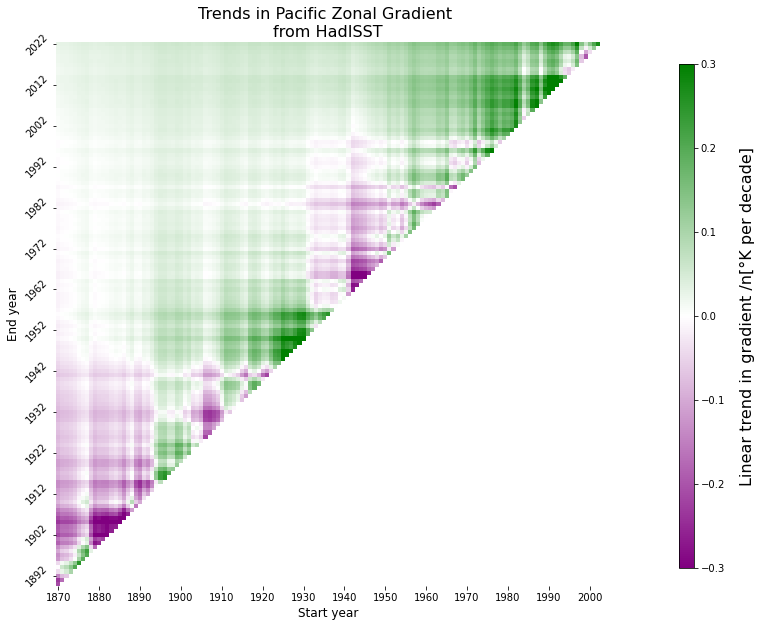

In [7]:
# the Had data has end dates that start at 1870 and start dates up to 2022; cropping so that we don't include those in the plot
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsHadDf = CropTrendsDf(trendsHadDf, offset)

# calculate the vmin and vmax
vmin = trendsHadDf.min().min()
vmax = trendsHadDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

# plotting the figure
fig = plt.figure(figsize = (10,10))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsHadDf, 'Trends in Pacific Zonal Gradient \nfrom HadISST', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient /n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

plt.show()

## 3) Read back in the trend data and calculate the 95% interval

Adding in functionality here, per Jason and Richard:  
Percentile where the observation lies  
Variance for each (maybe difference between 95% and 5%)

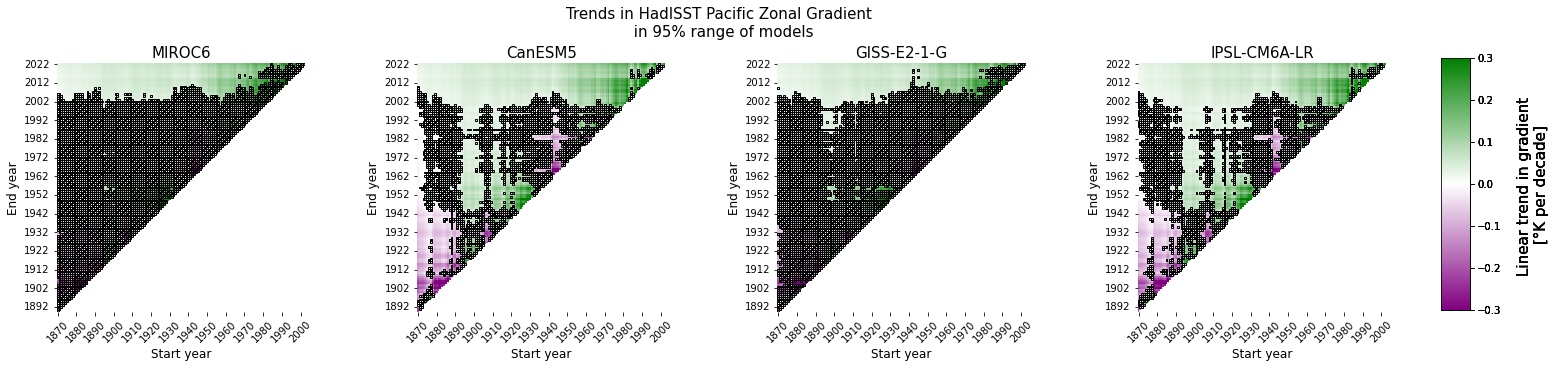

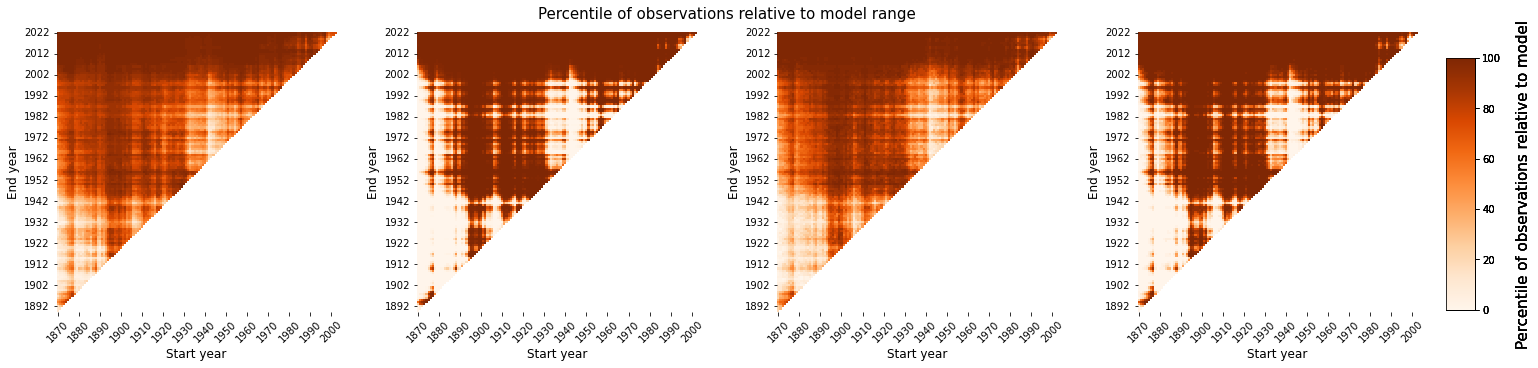

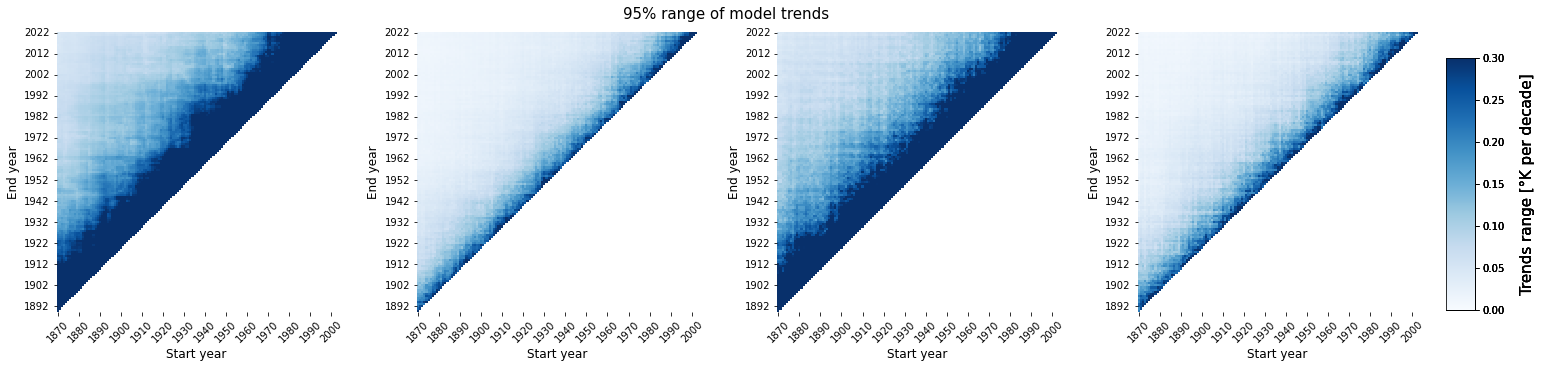

In [86]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends_240311'
os.chdir(trendsDir)

# model names so it can loop through and just select those models
models = ['MIROC6', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']

# establishing some dictionaries to hold universal values (for now just universal 95% and 5% for all models)
dictLowerUni = defaultdict(list)
dictUpperUni = defaultdict(list)

# ___Plotting Figures____

# __Universal attributes___
nFigures = len(models)
nCols = 4

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig1 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig1.suptitle('Trends in HadISST Pacific Zonal Gradient \n in 95% range of models', fontsize = 15)

# ___Obs percentile___
fig2 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig2.suptitle('Percentile of observations relative to model range', fontsize = 15)

# __Model range___
fig3 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig3.suptitle('95% range of model trends', fontsize = 15)


for i, model in enumerate(models):
    
    # create a dictionary with all of the trends from this directory
    trendsDict = TrendsDictFromFiles(trendsDir, model)
    
    # create dictionaries with lower and upper percentiles from the distribution of trends
    dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)
    
    # saving these values to the universal dictionaries (entire dictionaries where each main key is the model name)
    dictLowerUni[model] = dictLower
    dictUpperUni[model] = dictUpper

    # flagging everywhere that the values lie within the range of the models
    dictObsInRange = FlagInRange(dictLower, dictUpper, trendsHad)

    # creating a dataframe for the ObsInRange
    dfObsInRange = DictToDf(dictObsInRange)

    # removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
    keepRows = [row for row in dfObsInRange.index if row >= 1890]
    dfObsInRange = dfObsInRange.loc[keepRows, :]
    
    # calculating obs percentile
    dfObsPercentile = CalculateObsPercentile(trendsDict, trendsHad)
    
    # calculating total range
    dfRange = CalculateModelRange(dictLower, dictUpper)
    
    # plotting
    
    #___OBS IN RANGE___

    # calculate the vmin and vmax
    vmin = trendsHadDf.min().min()
    vmax = trendsHadDf.max().max()

    # find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
    if (vmin < 0) & (vmax > 0):
        limit = max(abs(vmin), abs(vmax))
        vmin = -limit
        vmax = limit

    vmin = -0.3
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.50,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig1.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig1.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig1.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 15)

    # adding the stippling with a for loop
    for a, row in enumerate(dfObsInRange.values):
        for b, value in enumerate(row):
            if value == 1:
                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=False, edgecolor='black', hatch='////'))
                
    #___OBS PERCENTILE___
    # set max and min though they will always be the same
    vmin = 0
    vmax = 100

    # setting the colorbar
    cmap = 'Oranges'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig2.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfObsPercentile, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig2.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig2.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Percentile of observations relative to model', rotation = 90, labelpad = 15, fontsize = 15)
    
    #___OBS RANGE___
    
    vmin = 0
    vmax = 0.3 # Note that these values were selected after running it once and looking at the max and min of the whole spread; have to be changed manually
    
    # setting the colorbar
    cmap = 'Blues'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig3.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')    
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfRange, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig3.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Trends range [°K per decade]', rotation = 90, labelpad = 15, fontsize = 15)
    

plt.show()

In [68]:
dictUpperUni = defaultdict(list)

In [70]:
dictUpperUni[model] = dictUpper

In [76]:
vmax = max(value for model in dictUpperUni.values() for value in model.values() if not np.isnan(value))

In [77]:
vmax

0.28045167803126

#### Flagging values in the 95% range

In [9]:
# create dictionaries with lower and upper percentiles from the distribution of trends
dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)

# flagging everywhere that the values lie within the range of the models
dictObsInRange = FlagInRange(dictLower, dictUpper, trendsHad)

# creating a dataframe for the ObsInRange
dfObsInRange = DictToDf(dictObsInRange)

# removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
keepRows = [row for row in dfObsInRange.index if row >= 1890]
dfObsInRange = dfObsInRange.loc[keepRows, :]

#### Calculating percentile of Obs relative to model range

In [25]:
dfObsPercentile = CalculateObsPercentile(trendsDict, trendsHad)

#### Calculating total 95% range for each model

In [19]:
dfRange = CalculateModelRange(dictLower, dictUpper)

### Plotting results

#### 95% range

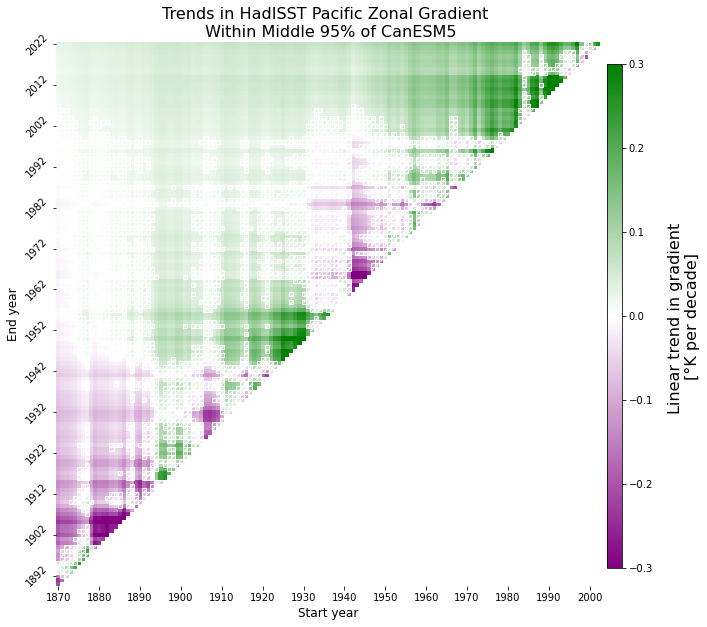

In [43]:
# plotting a better overlapping map (i.e., with stippling)

# starting with the observational plots

# calculate the vmin and vmax
vmin = trendsHadDf.min().min()
vmax = trendsHadDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
plt.xticks(rotation=0)
plt.yticks(rotation=45)
title = 'Trends in HadISST Pacific Zonal Gradient \n Within Middle 95% of CanESM5'
plt.title(title, fontsize = 16)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

# adding the stippling with a for loop
for i, row in enumerate(dfObsInRange.values):
    for j, value in enumerate(row):
        if value == 1:
            plot.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='white', hatch='////'))

plt.show()

#### Percentile

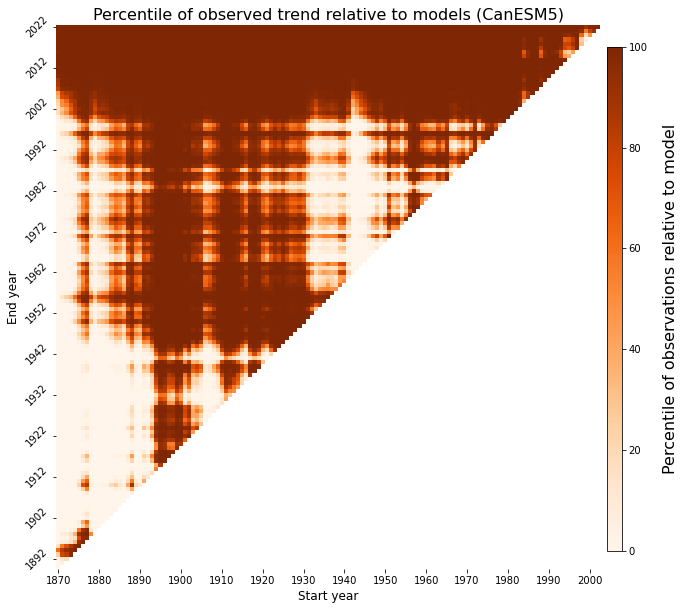

In [24]:
# this will need to be a heatmap

# set max and min though they will always be the same
vmin = 0
vmax = 100

# setting the colorbar
cmap = 'Oranges'
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, axes = plt.subplots(figsize = (10,10))
axes.set_aspect('equal')
plot = sns.heatmap(dfObsPercentile, cmap = cmap, ax = axes, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
plt.xticks(rotation=0)
plt.yticks(rotation=45)
title = 'Percentile of observed trend relative to models (CanESM5)'
plt.title(title, fontsize = 16)
plt.ylabel('End year', fontsize = 12)
plt.xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Percentile of observations relative to model', rotation = 90, labelpad = 15, fontsize = 16)

#### 95% range

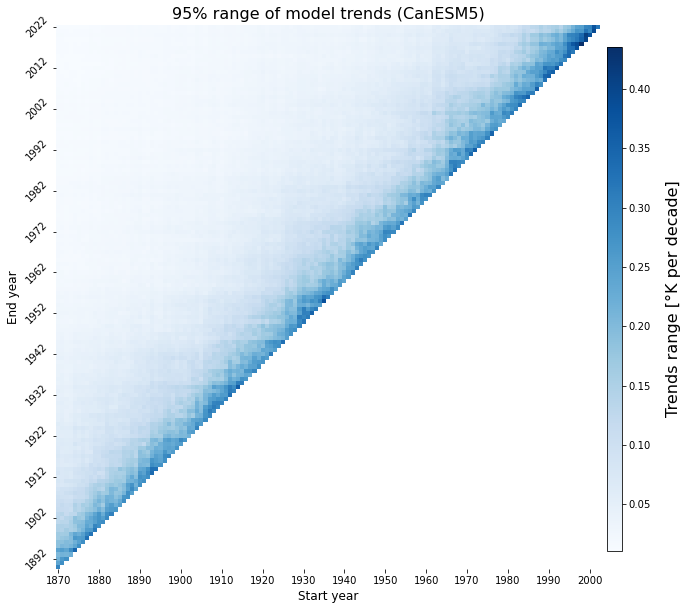

In [18]:
# this will need to be a heatmap

# calculating vmin and vmax
# calculate the vmin and vmax
vmin = dfRange.min().min()
vmax = dfRange.max().max()

# setting the colorbar
cmap = 'Blues'
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, axes = plt.subplots(figsize = (10,10))
axes.set_aspect('equal')
plot = sns.heatmap(dfRange, cmap = cmap, ax = axes, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
plt.xticks(rotation=0)
plt.yticks(rotation=45)
title = '95% range of model trends (CanESM5)'
plt.title(title, fontsize = 16)
plt.ylabel('End year', fontsize = 12)
plt.xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Trends range [°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

### Creating this analysis in a loop

## Calculating the MM mean of the gradient (i.e., averaging the time series from the distinct inputs)

In [6]:
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients'
gradientMean = CalculateMMEGradient(gradientsDir)

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Now running the trend class on it

In [7]:
trends = Trend(gradientMean).trends
trendsDf = Trend(gradientMean).trendsDf

## Plotting the trends

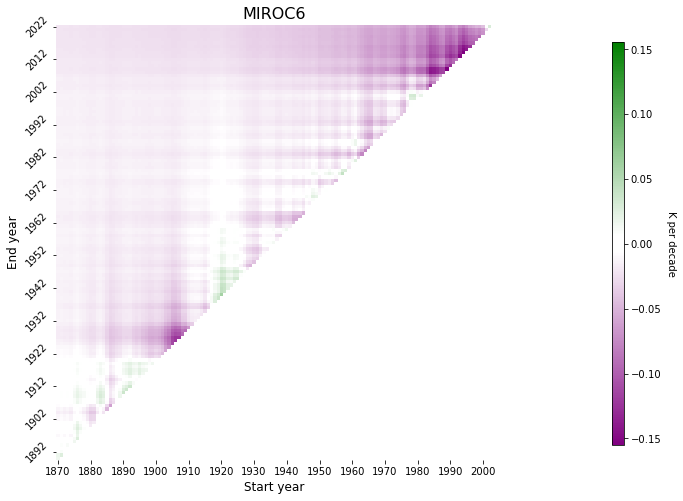

In [8]:
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (8,8))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDfCrop, 'MIROC6', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.show()

# Observational dataset input and calculation

In [9]:
obsDir = '/home/hbyrne/Research/QMDA_2023'
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [10]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trends = Trend(gradient).trends
trendsDf = Trend(gradient).trendsDf

## Plotting the trends

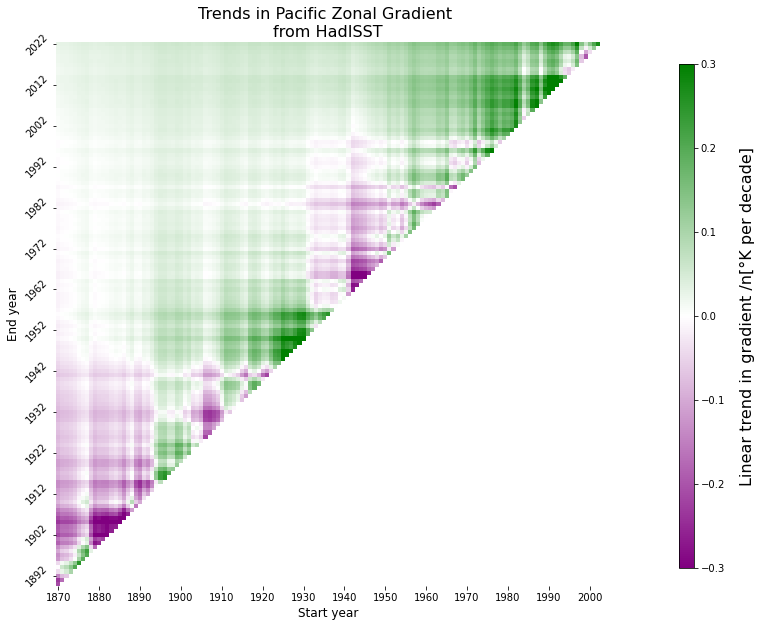

In [46]:
# the Had data has end dates that start at 1870 and start dates up to 2022; cropping so that we don't include those in the plot
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDf = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (10,10))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDf, 'Trends in Pacific Zonal Gradient \nfrom HadISST', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient /n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

plt.show()

# Calculating distributions of trends for each start and end date, plotting obs versus that

In [12]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends'
os.chdir(trendsDir)

In [76]:
# create a dictionary with all of the trends from this directory
trendsDict = TrendsDictFromFiles(trendsDir)

In [85]:
# create dictionaries with lower and upper percentiles from the distribution of trends
dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)

In [93]:
# flagging everywhere that the values lie within the range of the models
dictObsInRange = FlagInRange(dictLower, dictUpper, trends)

In [94]:
# creating a dataframe
dfObsInRange = DictToDf(dictObsInRange)

# removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
keepRows = [row for row in dfObsInRange.index if row >= 1890]
dfObsInRange = dfObsInRange.loc[keepRows, :]

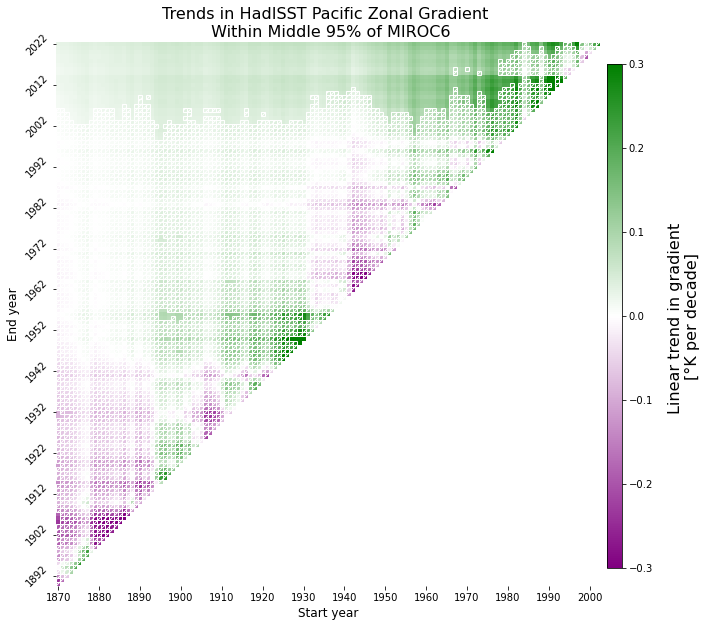

In [95]:
# plotting a better overlapping map (i.e., with stippling)

# starting with the observational plots

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
plot = sns.heatmap(trendsDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
plt.xticks(rotation=0)
plt.yticks(rotation=45)
title = 'Trends in HadISST Pacific Zonal Gradient \n Within Middle 95% of MIROC6'
plt.title(title, fontsize = 16)
plt.ylabel('End year', fontsize = 12)
plt.xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

# adding the stippling with a for loop
for i, row in enumerate(dfObsInRange.values):
    for j, value in enumerate(row):
        if value == 1:
            plot.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='white', hatch='////'))

plt.show()